In [ ]:
import os
os.getcwd()
%cd /content
!ls

/content
sample_data


In [ ]:
### Define Data and Dataloader
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Group dataset(s) (replace with relevant csv files)
file = "./BrennanTrain(1).csv"

# Load dataset(s)
#data = pd.concat([pd.read_csv(file) for file in csv], ignore_index=True)  # Concatenate each csv file into one data set
data = pd.read_csv(file)

# Step 1: Handle Missing Values
print("\nMissing Values per Column:")
print(data.isnull().sum())  # Check for missing values
data.fillna(0, inplace=True)  # Fill missing values with 0 (or other strategies)

# Step 2: Extract Time-Based Features
data['Date'] = pd.to_datetime(data['Date'])  # Let pandas infer the format

# Since Hour is already in the dataset, you can use it directly, or you can extract more time features
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['weekday'] = data['Date'].dt.weekday
data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclical encoding of hour and month
data['hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Step 3: Feature and Target
features = [
    "Hour",
    "temperature_2m...C.",
    "relative_humidity_2m....",
    "precipitation..mm.",
    "cloud_cover....",
    "cloud_cover_low....",
    "cloud_cover_mid....",
    "cloud_cover_high....",
    "wind_speed_10m..km.h.",
    "shortwave_radiation..W.m..",
    "direct_radiation..W.m..",
    "diffuse_radiation..W.m..",
    "direct_normal_irradiance..W.m..",
    "global_tilted_irradiance..W.m..",
    "hour_sin", "hour_cos", "month_sin", "month_cos"  # Add cyclical features
]
target = [# unavailible
] 

# Normalize features
scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(data[features])

# Normalize target
scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(data[target]) # do not reshape now that we have 5 columns to predict

# Step 4: Create Sequences
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 24*7  # You can adjust this depending on the length of time you want to consider
X, y = create_sequences(features_scaled, target_scaled, sequence_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=False)

# Step 6: Create DataLoader
class SolarDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

train_dataset = SolarDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=24*5, shuffle=False)

test_dataset = SolarDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=24*5, shuffle=False)

# Check data shapes
print(f"Features shape: {X_tensor.shape}")
print(f"Target shape: {y_tensor.shape}") # should be n by 5
print(f"Test shape: {X_test.shape}")

In [ ]:
# Get the first and last date
first_date = data['Date'].min()
last_date = data['Date'].max()
# Step 5: Train-Test Split

# Print the first and last date
print("First Date:", first_date)
print("Last Date:", last_date)
print(data['Date'][20304-4061])

First Date: 2022-04-03 00:00:00
Last Date: 2024-08-02 00:00:00
2024-02-08 00:00:00


In [ ]:
### Define GEN/DIS structure
import torch
import torch.nn as nn
import torch.optim as optim

class Generator(nn.Module):
    def __init__(self, noise_dim, condition_dim, output_dim, seq_len, dropout_rate=0.5):
        super(Generator, self).__init__()

        self.seq_len = seq_len

        # Define the LSTM layers with varying hidden size and layers
        # Impliment batch normalization after each layer
        # Impliment skip connections for each layer

        # Final output (combine skip connections)
        final_output = (x + skip_out1 + skip_out2 + skip_out3)/ 3.0
        final_output = self.fc(final_output)
        # Fully connected layer to generate the final output (kWh)
        final_output = self.relu(final_output)  # Apply ReLU activation

        return final_output

class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim, seq_length, dropout_rate=0.5):
        super(Discriminator, self).__init__()

        self.seq_len = seq_length

        # Define LSTM layers with varying hidden size and layers
        # Impliment batch normalization and dropout
        # Add skip connections

        # Combine skip connections and fully connected layer
        final_output = (x + skip_out1 + skip_out2 + skip_out3) / 3.0  # Average the skip connections

        x = self.fc1(final_output)
        x = self.fc2(x)

        return self.sigmoid(x)  # Real/fake classification


In [ ]:
### Hyperparams

# Initialize models
noise_dim = 100  # Dimension of noise
# condition_dim = 16  # Number of input features (e.g., weather features + time-based features)
condition_dim = len(features)
output_dim = output
seq_length = 24*7  # Sequence length (e.g., 24 hours)

# Hyperparameters
epochs = 100
batch_size = 24*5
lr = 0.0002
beta1 = 0.1
real_label = 1.0
fake_label = 0.0
step_size = 50  # Every 10 epochs, reduce the learning rate
gamma = 0.1  # Factor by which the learning rate will be reduced
# Hyperparameters for gradient clipping
max_grad_norm = 1.0  # Set this to the value you prefer (1.0 is commonly used)

In [ ]:
# Initialize the models again
generator = Generator(noise_dim, condition_dim, output_dim, seq_length)
#discriminator = Discriminator(output_dim, condition_dim, seq_length)
# New dis architecture
discriminator = Discriminator(output_dim, output_dim, condition_dim, seq_length)

# Load the saved weights
checkpoint = torch.load("metaGen.pth")
print("Current epochs: ", checkpoint['epoch'])
generator.load_state_dict(checkpoint['state_dict'])

# Set the models to evaluation mode
generator.eval()

print("Models loaded successfully!")


A
B
Current epochs:  40
Models loaded successfully!


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr  # For Pearson's correlation

### Overall model stats
# Ensure the Generator is in evaluation mode
generator.eval()

# Prepare noise for the test set
noise_dim = 100  # Same noise dimension used during training
test_size = X_test.size(0)  # Number of test samples
noise = torch.randn(test_size, noise_dim)

# Generate predictions using the Generator
with torch.no_grad():
    y_pred_scaled = generator(noise, X_test)

# Inverse transform the predictions and true values to original scale
y_pred = scaler_target.inverse_transform(y_pred_scaled.numpy())
y_true = scaler_target.inverse_transform(y_test.numpy())

# Evaluate the predictions (Optional)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# Calculate NRMSE using Pmax
# Calculate the maximum and minimum of the true values (y_max and y_min)
y_max = np.max(y_true)
y_min = np.min(y_true)
nrmse_pmax = (rmse / y_max - y_min) * 100
nrmse_avg = (rmse / np.mean(y_true)) * 100

# Calculate R² (Coefficient of Determination)
r2 = r2_score(y_true, y_pred)

# Calculate Pearson's Correlation Coefficient
pearson_corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())  # Flatten to 1D arrays for correlation

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Normalized RMSE (Pmax): {nrmse_pmax:.4f}%")
print(f"Normalized RMSE (Average): {nrmse_avg:.4f}%")
print(f"Coefficient of Determination (R²): {r2:.4f}")
print(f"Pearson's Correlation Coefficient(R): {pearson_corr:.4f}")

Mean Absolute Error (MAE): 127.1102
Root Mean Square Error (RMSE): 241.6475
Normalized RMSE (Pmax): 12.1392%
Normalized RMSE (Average): 69.7715%
Coefficient of Determination (R²): 0.7658
Pearson's Correlation Coefficient(R): 0.9206


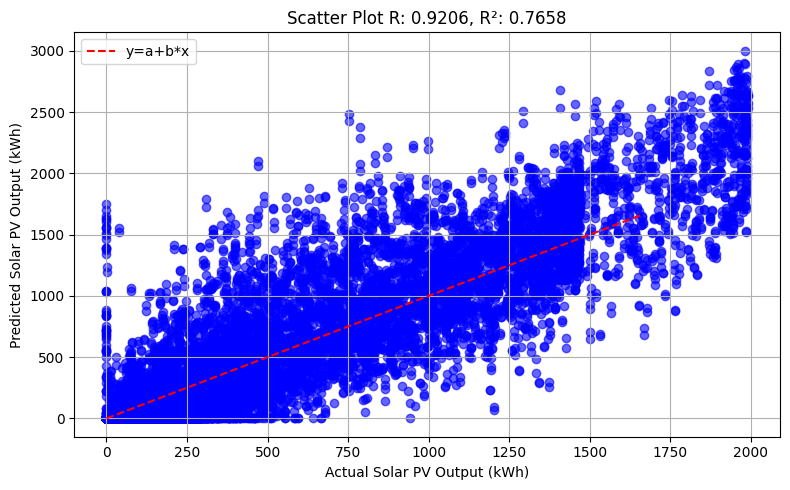

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Calculate R² and Pearson's correlation coefficient (R)
r2 = r2_score(y_true, y_pred)
pearson_corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())  # Flattening to 1D arrays for correlation

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.6, color='blue')

# Plot a line representing perfect prediction (45-degree line)
# Has issues cuz we are doing 5 sites. Use average
miny = np.mean(np.min(y_true, axis=0))
maxy = np.mean(np.max(y_true, axis=0))

plt.plot([miny, maxy], [miny, maxy], color='red', linestyle='--', label='y=a+b*x')

# Annotate the plot with R and R² values
plt.title(f"Scatter Plot R: {pearson_corr:.4f}, R²: {r2:.4f}")
plt.xlabel("Actual Solar PV Output (kWh)")
plt.ylabel("Predicted Solar PV Output (kWh)")
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

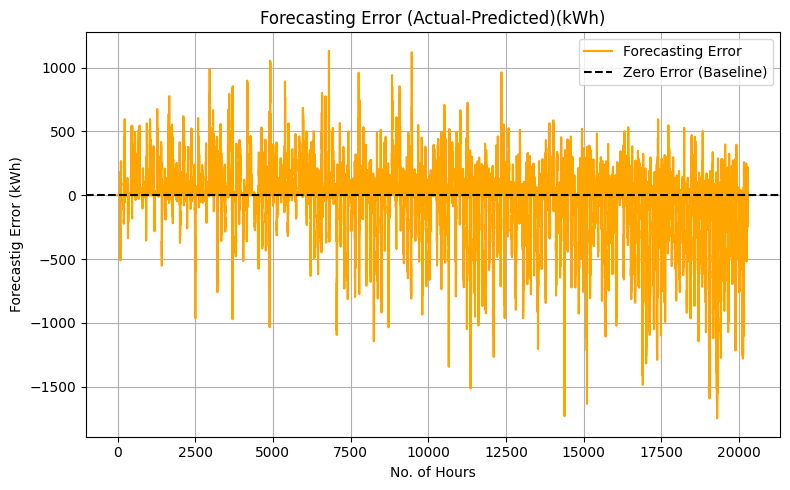

In [ ]:
# Calculate the forecasting error (actual - predicted)
error = y_true.flatten() - y_pred.flatten()

# Create the plot
plt.figure(figsize=(8, 5))

# Plot the error for each hour
hours = np.arange(1, len(error) + 1)  # Assuming hourly data, adjust if needed
plt.plot(hours, error, color='orange', label='Forecasting Error')

# Add a horizontal line for the baseline (0 error)
plt.axhline(0, color='black', linestyle='--', label='Zero Error (Baseline)')

# Adding titles and labels
plt.title("Forecasting Error (Actual-Predicted)(kWh)")
plt.xlabel("No. of Hours")
plt.ylabel("Forecastig Error (kWh)")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

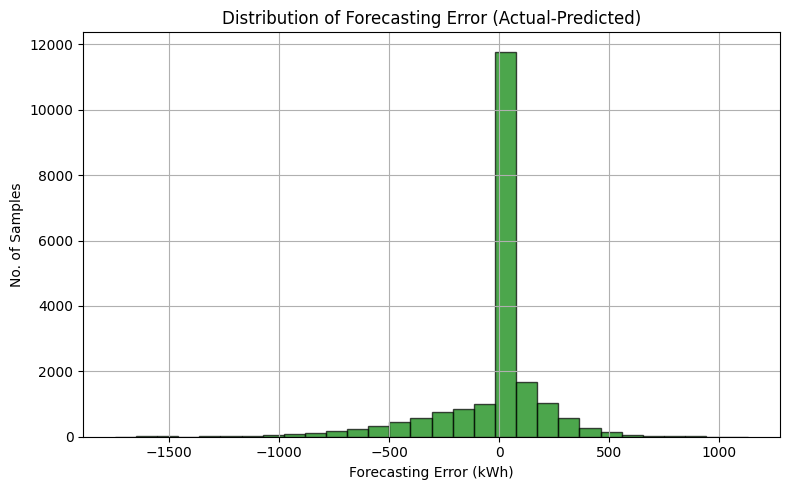

In [ ]:
# Calculate the forecasting error (actual - predicted)
error = y_true.flatten() - y_pred.flatten()

# Create the histogram plot for error distribution
plt.figure(figsize=(8, 5))

# Plot the histogram of the error distribution
plt.hist(error, bins=30, color='green', edgecolor='black', alpha=0.7)

# Adding titles and labels
plt.title("Distribution of Forecasting Error (Actual-Predicted)")
plt.xlabel("Forecasting Error (kWh)")
plt.ylabel("No. of Samples")
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

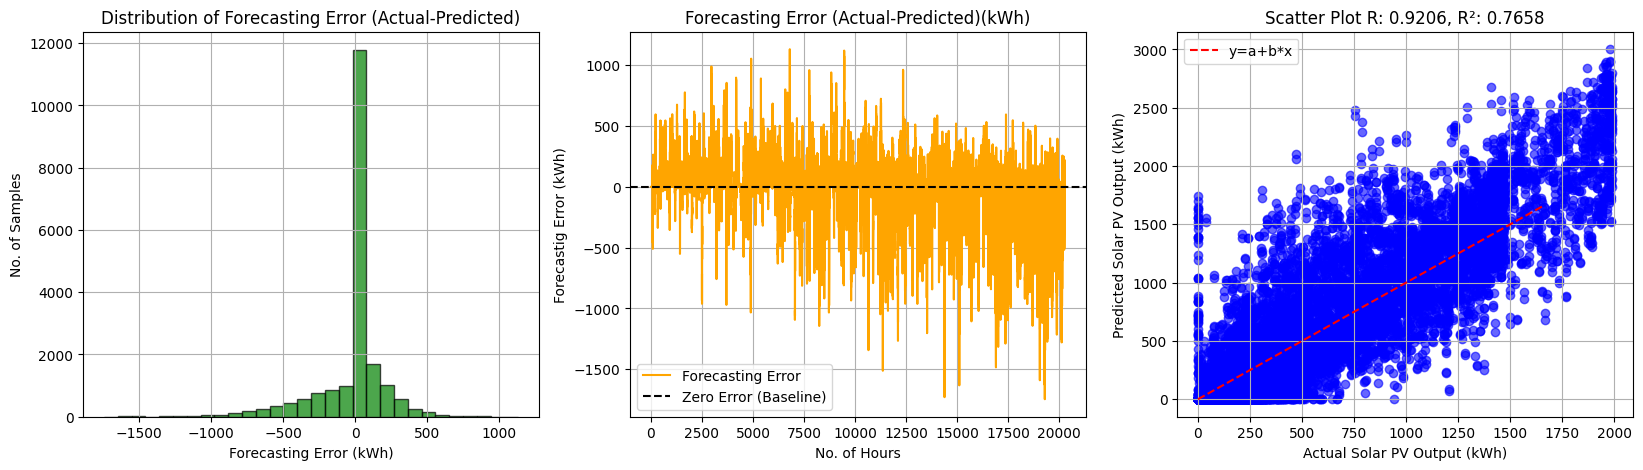

In [ ]:
fig = plt.figure(figsize=(20, 5))

# Plot all 3 on the same sub:
p1 = plt.subplot(1, 3, 1)

# Plot the histogram of the error distribution
p1.hist(error, bins=30, color='green', edgecolor='black', alpha=0.7)

# Adding titles and labels
p1.set_title("Distribution of Forecasting Error (Actual-Predicted)")
p1.set_xlabel("Forecasting Error (kWh)")
p1.set_ylabel("No. of Samples")
p1.grid(True)

# Plot the error for each hour
p2 = plt.subplot(1, 3, 2)
hours = np.arange(1, len(error) + 1)  # Assuming hourly data, adjust if needed
p2.plot(hours, error, color='orange', label='Forecasting Error')

# Add a horizontal line for the baseline (0 error)
p2.axhline(0, color='black', linestyle='--', label='Zero Error (Baseline)')

# Adding titles and labels
p2.set_title("Forecasting Error (Actual-Predicted)(kWh)")
p2.set_xlabel("No. of Hours")
p2.set_ylabel("Forecastig Error (kWh)")
p2.legend()
p2.grid(True)

p3 = plt.subplot(1, 3, 3)
p3.scatter(y_true, y_pred, alpha=0.6, color='blue')

# Plot a line representing perfect prediction (45-degree line)
# Has issues cuz we are doing 5 sites. Use average
miny = np.mean(np.min(y_true, axis=0))
maxy = np.mean(np.max(y_true, axis=0))

p3.plot([miny, maxy], [miny, maxy], color='red', linestyle='--', label='y=a+b*x')

# Annotate the plot with R and R² values
p3.set_title(f"Scatter Plot R: {pearson_corr:.4f}, R²: {r2:.4f}")
p3.set_xlabel("Actual Solar PV Output (kWh)")
p3.set_ylabel("Predicted Solar PV Output (kWh)")
p3.legend()
p3.grid(True)

# Show plot
plt.show()

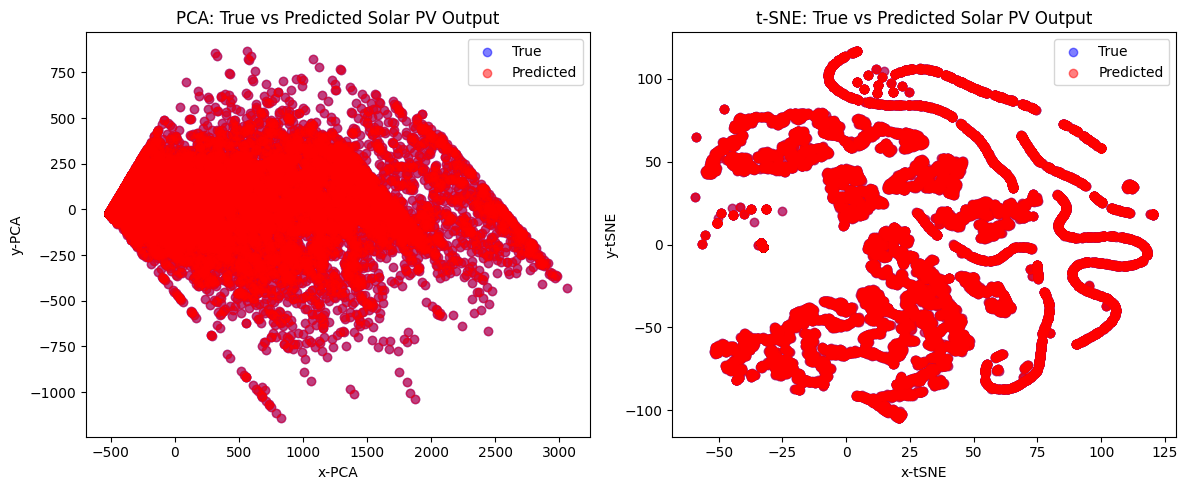

Average Cosine Similarity: 0.9437
Average Jensen-Shannon Divergence: 0.1905


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
import numpy as np
import matplotlib.pyplot as plt

# Ensure that y_true and y_pred are 2D arrays (e.g., shape = (samples, features))
# If they are not, we might need to flatten them or adjust their shape
# For now, we assume they are 2D or use the flattened version.
y_true_flattened = y_true.flatten()
y_pred_flattened = y_pred.flatten()

# 1. PCA Visualization

# Combine the real and predicted values into one dataset for PCA
data_combined = np.vstack([y_true_flattened, y_pred_flattened]).T

# Apply PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_combined)

# 2. t-SNE Visualization

# Apply t-SNE (reduce to 2 dimensions)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_combined)

# 3. Calculate Average Cosine Similarity

cos_sim = cosine_similarity(y_true_flattened.reshape(1, -1), y_pred_flattened.reshape(1, -1))[0]
avg_cos_similarity = np.mean(cos_sim)

# 4. Calculate Average Jensen-Shannon Divergence

# Rescale the vectors to probability distributions (normalize to sum to 1)
y_true_norm = y_true_flattened / np.sum(y_true_flattened)
y_pred_norm = y_pred_flattened / np.sum(y_pred_flattened)

jsd = jensenshannon(y_true_norm, y_pred_norm)
avg_jsd = np.mean(jsd)

# 5. Plot PCA and t-SNE

plt.figure(figsize=(12, 5))

# PCA Plot
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', label="True", alpha=0.5)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='red', label="Predicted", alpha=0.5)
plt.title('PCA: True vs Predicted Solar PV Output')
plt.xlabel('x-PCA')
plt.ylabel('y-PCA')
plt.legend()

# t-SNE Plot
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='blue', label="True", alpha=0.5)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='red', label="Predicted", alpha=0.5)
plt.title('t-SNE: True vs Predicted Solar PV Output')
plt.xlabel('x-tSNE')
plt.ylabel('y-tSNE')
plt.legend()

plt.tight_layout()
plt.show()

# Output similarity scores
print(f"Average Cosine Similarity: {avg_cos_similarity:.4f}")
print(f"Average Jensen-Shannon Divergence: {avg_jsd:.4f}")